In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [3]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [4]:
from sklearn import model_selection
from sklearn.metrics import accuracy_score

In [5]:
#import training data
PG_train = pd.read_csv("train_V2.csv")

In [6]:
print(f'There are {PG_train.shape[0]} samples and {PG_train.shape[1]} features in the training PUBG V2 dataset.')

There are 4446966 samples and 29 features in the training PUBG V2 dataset.


In [7]:
pd.set_option('display.max_columns', None)
PG_train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [8]:
#I want to see the relationship between maxPlace, the true ranking from 1-100, with damageDealt.
#In other words, do you get better ranking if you deal more damage, and logically, by getting in fights?
data = []
for asset in np.random.choice(PG_train['Id'].unique(), 200):
    asset_df = PG_train[(PG_train['Id'] == asset)]

    data.append(go.Scatter(
        x = asset_df['damageDealt'].values,
        y = asset_df['maxPlace'].values,
        name = asset,
        showlegend=False
    ))
layout = go.Layout(dict(title = "Killing is Winning?",
                  xaxis = dict(title = 'Damage (Higher is Better)'),
                  yaxis = dict(title = 'Rank (Lower is Better)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

The reality is that there's no real relationship between damageDealt and final place. This is because the max value in maxPlace differs per matchType.

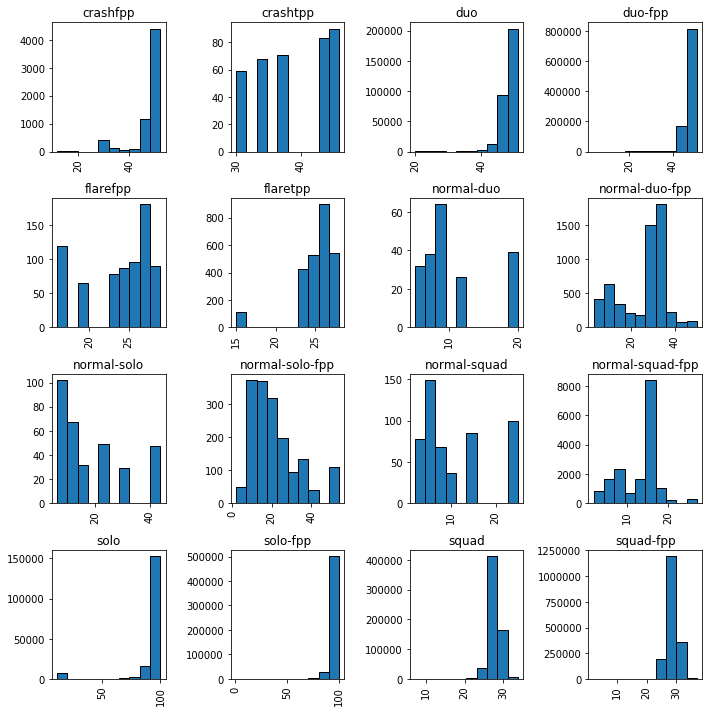

In [9]:
fig = PG_train['maxPlace'].hist(by=PG_train['matchType'],figsize=(10,10),ec="k")
plt.tight_layout()

Those histograms are interesting to bear in mind. Obviously, the distributions depend on how the data was collected: why is that important? because Ids (players) are picked randomly across 1000s of games, while in a single game everyone get one and unique place/ranking - though they might have more or less killPoints. What matters however is the place (maxPlace) at the end of the game.

In [10]:
PG_train["matchType"].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536762
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

Looking at the distribution of the different matchType variable. I might remove all the ones under 'solo' as they represent very little to the total. With this said, I might make separate training models for them after the main types.

In [11]:
PG_train.groupby(['matchType'], sort=False)['maxPlace'].max()

matchType
squad-fpp            37
duo                  51
solo-fpp            100
squad                34
duo-fpp              51
solo                100
normal-squad-fpp     27
crashfpp             52
flaretpp             28
normal-solo-fpp      54
flarefpp             29
normal-duo-fpp       50
normal-duo           20
normal-squad         25
crashtpp             46
normal-solo          44
Name: maxPlace, dtype: int64

The difficulty in creating one unique predictive algorithm is that game parameters are very different from one matchType to another.

I think I'll split the dataset per matchType or to simplify, split between solo, duo and squad, though squad can also be played as solo or duo. So I might train the model on squad only (squad-fpp+squad) and see if how it works for the other matchTypes. Though I could train a model across the entire dataset regardless of matchType, I can't do it at this stage because my computer can't manage it: splitting analysis by matchType might help to lower CPU usage.

In [14]:
PG_train['winPlacePerc'].nunique()

3000

In [13]:
PG_train.groupby(['winPlacePerc'], sort=False)['maxPlace'].max()

winPlacePerc
0.4444    100
0.6400     76
0.7755     99
0.1667     97
0.1875     97
0.0370     82
0.0000    100
0.7368     96
0.3704     82
0.2143     99
0.3929     85
0.4043     95
0.9286     99
0.8750     97
0.9000     91
0.2766     95
0.7308     79
0.8211     96
0.1923     79
0.9310     88
0.6383     95
0.7500     97
0.9592     99
0.9231     92
0.8696     93
0.1154     79
0.7234     95
0.9630     82
0.4255     95
0.0667     91
         ... 
0.4714     71
0.6711     77
0.3443     62
0.1148     62
0.8070     58
0.9423     53
0.6167     61
0.1311     62
0.4833     61
0.8833     61
0.1268     72
0.2687     68
0.4098     62
0.7115     53
0.2237     77
0.2742     63
0.9344     62
0.0635     64
0.0423     72
0.5915     72
0.0164     62
0.4366     72
0.9859     72
0.2167     61
0.0577     53
0.6212     67
0.0845     72
0.1207     59
0.4561     58
0.2879     67
Name: maxPlace, Length: 3000, dtype: int64

In [ ]:
PG_train.groupby(['winPlacePerc'], sort=False)['maxPlace'].min()

In [ ]:
fig2 = PG_train['maxPlace'].hist(by=PG_train['winPlacePerc'],figsize=(10,10),ec="k")
plt.tight_layout()